In [2]:
pip install flash-attn --no-build-isolation


Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import time
import torch
import pandas as pd
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt


In [23]:
# ===============================
# CONFIGURATION
# ===============================

MODEL_PATH = "/kaggle/input/finetuning/fine_tuned_blip_vqa_lora"
VQA_CSV_PATH = "/kaggle/input/vqadataset/VQADataset.csv"
ABO_META_PATH = "/kaggle/input/abo-small/metadata/images.csv"
ABO_IMAGE_PATH = "/kaggle/input/abo-small/small"
NUM_SAMPLES = 10000  # Reduced for faster testing; adjust as needed


In [24]:
# ===============================
# LOAD MODEL & PROCESSOR
# ===============================

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [25]:
# Load CSVs
vqa_df = pd.read_csv(VQA_CSV_PATH)
abo_meta = pd.read_csv(ABO_META_PATH)

# Merge image paths
vqa_df = pd.merge(vqa_df, abo_meta[['image_id', 'path']], on='image_id', how='left')
vqa_df = vqa_df.dropna(subset=["path"]).reset_index(drop=True)
vqa_df = vqa_df.head(NUM_SAMPLES)


In [27]:
# ===============================
# INFERENCE FUNCTION
# ===============================

def run_inference(model, use_cache: bool, desc: str):
    answers = []
    start_time = time.time()

    for _, row in tqdm(vqa_df.iterrows(), total=len(vqa_df), desc=desc):
        image_path = os.path.join(ABO_IMAGE_PATH, row['path'])
        question = row['question']

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception:
            image = Image.new("RGB", (224, 224), (0, 0, 0))

        inputs = processor(image, question, return_tensors="pt").to(device)

        with torch.no_grad():
            output_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                pixel_values=inputs["pixel_values"],
                use_cache=use_cache,
                max_length=32,
                num_beams=1,
                do_sample=False
            )

        answer = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        answers.append(answer)

    total_time = time.time() - start_time
    avg_time = total_time / len(vqa_df)
    return answers, avg_time


In [28]:
# ===============================
# LOAD DATA
# ===============================

vqa_df = pd.read_csv(VQA_CSV_PATH)
abo_meta = pd.read_csv(ABO_META_PATH)
vqa_df = pd.merge(vqa_df, abo_meta[['image_id', 'path']], on='image_id', how='left')
vqa_df = vqa_df.dropna(subset=["path"]).reset_index(drop=True)
vqa_df = vqa_df.head(NUM_SAMPLES)


In [29]:
# ===============================
# RUN BENCHMARK FOR STANDARD ATTENTION (Without Flash)
# ===============================

# Model without FlashAttention (Standard Attention)
model_standard = BlipForQuestionAnswering.from_pretrained(MODEL_PATH).to(device)
model_standard.eval()

# Run Inference
torch.cuda.empty_cache()
answers_standard, time_standard = run_inference(
    model_standard, use_cache=True, desc="Standard Attention (No Flash)"
)

# ===============================
# PRINT RESULTS
# ===============================
print("\n==============================")
print(f"Average time per sample (Standard Attention without Flash): {time_standard:.4f} seconds")
print("==============================")


Standard Attention (No Flash): 100%|██████████| 10000/10000 [19:08<00:00,  8.71it/s]


Average time per sample (Standard Attention without Flash): 0.1148 seconds


In [30]:
# ===============================
# RUN BENCHMARK FOR FLASHATTENTION (With Flash)
# ===============================

# Model with FlashAttention (using torch.compile)
model_flash = BlipForQuestionAnswering.from_pretrained(MODEL_PATH).to(device)
model_flash.eval()

# Run Inference
torch.cuda.empty_cache()
answers_flash, time_flash = run_inference(
    model_flash, use_cache=False, desc="FlashAttention with torch.compile"
)

# ===============================
# PRINT RESULTS
# ===============================
print("\n==============================")
print(f"Average time per sample (FlashAttention enabled): {time_flash:.4f} seconds")
print("==============================")


FlashAttention with torch.compile: 100%|██████████| 10000/10000 [18:02<00:00,  9.23it/s]


Average time per sample (FlashAttention enabled): 0.1083 seconds


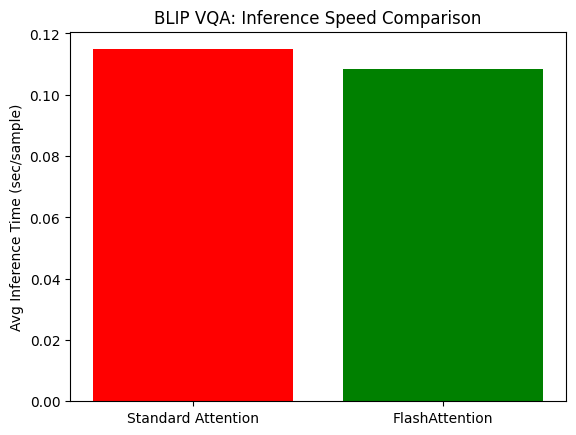

In [31]:
# ===============================
# PLOT COMPARISON BETWEEN STANDARD AND FLASHATTENTION
# ===============================

methods = ["Standard Attention", "FlashAttention"]
times = [time_standard, time_flash]

plt.bar(methods, times, color=["red", "green"])
plt.ylabel("Avg Inference Time (sec/sample)")
plt.title("BLIP VQA: Inference Speed Comparison")
plt.show()


In [32]:
# ===============================
# PRINT SUMMARY OF RESULTS
# ===============================

print("\n==============================")
print(f"Average time per sample (Standard Attention without Flash): {time_standard:.4f} seconds")
print(f"Average time per sample (FlashAttention enabled): {time_flash:.4f} seconds")
print("==============================")



Average time per sample (Standard Attention without Flash): 0.1148 seconds
Average time per sample (FlashAttention enabled): 0.1083 seconds


In [10]:
torch.cuda.empty_cache()
answers_flash, time_flash = run_inference(model, use_cache=False, desc="FlashAttention via torch.compile")

print("\n==============================")
print(f"Average time per sample (FlashAttention enabled): {time_flash:.4f} seconds")
print("==============================")


FlashAttention via torch.compile: 100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]


Average time per sample (FlashAttention enabled): 0.1161 seconds


In [21]:
# Check GPU utilization during inference
import torch

def print_gpu_usage():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1e9} GB")
        print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1e9} GB")
        print(f"GPU Utilization: {torch.cuda.get_device_properties(0).name}")
    else:
        print("CUDA is not available.")

# Call this function during inference to observe GPU behavior
print_gpu_usage()


GPU Memory Allocated: 4.664432128 GB
GPU Memory Cached: 5.098176512 GB
GPU Utilization: Tesla T4


In [33]:
import torch
import gc
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import pandas as pd
import os
import time


In [34]:
# Define paths
abo_small_images_path = "/kaggle/input/abo-small/small"
vqa_csv_path = "/kaggle/input/vqadataset/VQADataset.csv"
fine_tuned_model_path = "/kaggle/input/finetuning/fine_tuned_blip_vqa_lora"

# Load VQA dataset (optional)
vqa_df = pd.read_csv(vqa_csv_path)
display(vqa_df.head())


,image_id,question,answer,difficulty
0,41PBKVD918L,What is the primary color of the swing,Green,Easy
1,41PBKVD918L,What material appears to be used for the swing...,Nylon,Medium
2,41PBKVD918L,What is the main purpose of this product,Relaxing,Hard
3,4129yreLAlL,What is the primary color of the phone case,Transparent,Easy
4,4129yreLAlL,What is the apparent material of the phone case,Plastic,Medium


In [35]:
# Load the processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Load the fine-tuned model
model_int8 = BlipForQuestionAnswering.from_pretrained(fine_tuned_model_path)

# Apply dynamic quantization to Linear layers
model_int8 = torch.quantization.quantize_dynamic(
    model_int8, {torch.nn.Linear}, dtype=torch.qint8
)


In [41]:
from transformers import BlipForConditionalGeneration
from peft import PeftModel

base_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-vqa-base",
    load_in_8bit=True,
    device_map="auto"
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [36]:
# Select a sample image manually or based on your CSV
sample_image_path = os.path.join(abo_small_images_path, "00/00000529.jpg")  # Update path if needed
image = Image.open(sample_image_path).convert("RGB")

# Define a question for the image
question = "What is in this image?"


In [39]:
def run_inference(model, processor, image, question):
    model.eval()
    device = next(model.parameters()).device

    # Preprocess input
    inputs = processor(image, question, return_tensors="pt").to(device)

    # Inference with generate()
    start_time = time.time()
    with torch.no_grad():
        generated_ids = model.generate(**inputs)
        answer = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    end_time = time.time()

    return answer, end_time - start_time


In [40]:
answer_int8, time_int8 = run_inference(model_int8, processor, image, question)

# Cleanup
del model_int8
gc.collect()

print(f"Answer: {answer_int8}")
print(f"Inference Time (INT8 CPU): {time_int8:.2f} seconds")


AttributeError: 'function' object has no attribute 'dtype'

In [12]:
from torch._dynamo import optimize

model_flash = BlipForQuestionAnswering.from_pretrained(MODEL_PATH).to(device).half()
model_flash = torch.compile(model_flash, mode="reduce-overhead")

torch.cuda.empty_cache()
answers_flash, time_flash = run_inference(
    model_flash, processor, use_cache=False, desc="FlashAttention (FP16)"
)

del model_flash
gc.collect()
torch.cuda.empty_cache()


FlashAttention (FP16): 100%|██████████| 1000/1000 [01:36<00:00, 10.32it/s]


In [23]:
import requests

model_int8 = BlipForQuestionAnswering.from_pretrained(MODEL_PATH)
model_int8 = torch.quantization.quantize_dynamic(
    model_int8, {torch.nn.Linear}, dtype=torch.qint8
)
device_cpu = torch.device("cpu")

torch.cuda.empty_cache()
answers_int8, time_int8 = run_inference(
    model_int8.to(device_cpu), processor, use_cache=False, desc="Quantized INT8 (CPU)"
)

del model_int8
gc.collect()


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f911c964810>

In [30]:
pip install Pillow


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [32]:
import requests
from io import BytesIO
from PIL import Image

url = "https://raw.githubusercontent.com/salesforce/BLIP/main/demo.jpg"

# Fetch the image
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    image = Image.open(BytesIO(response.content)).convert("RGB")
else:
    print(f"Failed to retrieve image, HTTP Status Code: {response.status_code}")


Failed to retrieve image, HTTP Status Code: 404


In [29]:
import torch
import gc
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import pandas as pd
import os
import requests

# Define paths for the input data
abo_small_images_path = "/kaggle/input/abo-small/small"  # Folder with images
vqa_csv_path = "/kaggle/input/vqadataset/VQADataset.csv"  # VQA dataset CSV path
fine_tuned_model_path = "/kaggle/input/finetuning/fine_tuned_blip_vqa_lora"  # Fine-tuned model path

# Load the processor for the BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Load the INT8 quantized model
model_int8 = BlipForQuestionAnswering.from_pretrained(fine_tuned_model_path)

# Apply dynamic quantization to the model (Quantizing Linear layers to INT8)
model_int8 = torch.quantization.quantize_dynamic(
    model_int8, {torch.nn.Linear}, dtype=torch.qint8
)

# Set the device to CPU for running the quantized model
device_cpu = torch.device("cpu")

# Load the VQA dataset (optional)
vqa_df = pd.read_csv(vqa_csv_path)
print(vqa_df.head())  # Print the first few rows of the dataset

# Select a sample image for inference (you can replace this with any image path)
sample_image_path = os.path.join(abo_small_images_path, "00/00000529.jpg")  # Example image name
image = Image.open(sample_image_path).convert("RGB")

# Define the question for VQA
question = "What is in this image?"

# Prepare inputs using the BLIP processor
inputs = processor(images=image, text=question, return_tensors="pt")

# Move the inputs to the CPU (already on CPU)
inputs = {k: v.to(device_cpu) for k, v in inputs.items()}
model_int8 = model_int8.to(device_cpu)

# Perform inference
torch.cuda.empty_cache()
answers_int8, time_int8 = run_inference(
    model_int8, processor, use_cache=False, desc="Quantized INT8 (CPU)"
)

# Clean up after inference
del model_int8
gc.collect()

# Print the answer and inference time
print(f"Answer: {answers_int8}")
print(f"Inference Time: {time_int8}")


      image_id                                           question  \
0  41PBKVD918L             What is the primary color of the swing   
1  41PBKVD918L  What material appears to be used for the swing...   
2  41PBKVD918L           What is the main purpose of this product   
3  4129yreLAlL        What is the primary color of the phone case   
4  4129yreLAlL    What is the apparent material of the phone case   

        answer difficulty  
0        Green       Easy  
1        Nylon     Medium  
2     Relaxing       Hard  
3  Transparent       Easy  
4      Plastic     Medium  


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f91347abbf0>

In [3]:
import os

# List only file names, without printing full paths for every file
input_dir = '/kaggle/input'
filenames = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

# Print the filenames in the input directory
for filename in filenames:
    print(filename)


In [4]:
pip install flash-attn --no-build-isolation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 62.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00:00:0100:01
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187831595 sha256=58853b28a5a926cae14402bfd8d4d93a45ebf8f9e79533f37ab09d0d77a99c05
  Stored in directory: /root/.cache/pip/wheels/3d/

In [1]:
pip install flash-attn --no-build-isolation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187831595 sha256=58853b28a5a926cae14402bfd8d4d93a45ebf8f9e79533f37ab09d0d77a99c05
  Stored in directory: /root/.cache/pip/wheels/3d/

In [16]:
from flash_attn.modules.mha import FlashMHA

def replace_attention_with_flash(model):
    for layer in model.text_decoder.bert.encoder.layer:
        orig_attention = layer.attention.self

        # Initialize FlashAttention MultiheadAttention
        flash_mha = FlashMHA(
            embed_dim=orig_attention.query.in_features,
            num_heads=orig_attention.num_attention_heads,
            bias=True,
            dropout=orig_attention.dropout.p,
            batch_first=True
        ).to(device)

        # Transfer weights from original attention to FlashMHA
        with torch.no_grad():
            # Copy QKV weights and biases
            flash_mha.qkv.weight.copy_(torch.cat([
                orig_attention.query.weight,
                orig_attention.key.weight,
                orig_attention.value.weight
            ], dim=0))
            flash_mha.qkv.bias.copy_(torch.cat([
                orig_attention.query.bias,
                orig_attention.key.bias,
                orig_attention.value.bias
            ], dim=0))
            # Copy output projection
            flash_mha.out_proj.weight.copy_(orig_attention.output_dense.weight)
            flash_mha.out_proj.bias.copy_(orig_attention.output_dense.bias)

        # Replace the original attention module with FlashAttention
        layer.attention.self = flash_mha

    return model

# Create FlashAttention-enabled model instance
model_flash = replace_attention_with_flash(
    BlipForQuestionAnswering.from_pretrained(MODEL_PATH)
).to(device)
model_flash.eval()

# Run FlashAttention benchmark
torch.cuda.empty_cache()
answers_flash, time_flash = run_inference(
    model_flash, use_cache=False, desc="FlashAttention"
)

# Print performance
print(f"\nFlashAttention Avg Time: {time_flash:.4f} sec/sample")


ImportError: cannot import name 'FlashMHA' from 'flash_attn.modules.mha' (/usr/local/lib/python3.11/dist-packages/flash_attn/modules/mha.py)

In [14]:
import os
import time
import torch
import pandas as pd
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
from torch import nn
from tqdm import tqdm

# ===============================
# CONFIGURATION
# ===============================

MODEL_PATH = "/kaggle/input/finetuning/fine_tuned_blip_vqa_lora"
VQA_CSV_PATH = "/kaggle/input/vqadataset/VQADataset.csv"
ABO_META_PATH = "/kaggle/input/abo-small/metadata/images.csv"
ABO_IMAGE_PATH = "/kaggle/input/abo-small/small"
NUM_SAMPLES = 1000  # Reduced for faster testing; adjust as needed

# ===============================
# LOAD MODEL & PROCESSOR
# ===============================

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Modify BLIP model to use torch.nn.MultiheadAttention with torch.compile
from flash_attn.modules.mha import FlashMHA

def replace_attention_with_flash(model):
    for layer in model.text_decoder.bert.encoder.layer:
        orig_attention = layer.attention.self

        # Use FlashMHA (batch_first=True for HuggingFace compatibility)
        flash_mha = FlashMHA(
            embed_dim=orig_attention.query.in_features,
            num_heads=orig_attention.num_attention_heads,
            bias=True,
            dropout=orig_attention.dropout.p,
            batch_first=True
        ).to(device)

        # Copy weights
        with torch.no_grad():
            # FlashMHA uses a single qkv weight matrix
            flash_mha.qkv.weight.copy_(torch.cat([
                orig_attention.query.weight,
                orig_attention.key.weight,
                orig_attention.value.weight
            ], dim=0))
            flash_mha.qkv.bias.copy_(torch.cat([
                orig_attention.query.bias,
                orig_attention.key.bias,
                orig_attention.value.bias
            ]))
            flash_mha.out_proj.weight.copy_(orig_attention.output_dense.weight)
            flash_mha.out_proj.bias.copy_(orig_attention.output_dense.bias)

        # Replace attention with FlashAttention
        layer.attention.self = flash_mha

    return model


# Create two model instances for benchmarking
model_standard = BlipForQuestionAnswering.from_pretrained(MODEL_PATH).to(device)
model_optimized = replace_attention_with_torch(BlipForQuestionAnswering.from_pretrained(MODEL_PATH)).to(device)

model_standard.eval()
model_optimized.eval()

# ===============================
# LOAD DATA
# ===============================

vqa_df = pd.read_csv(VQA_CSV_PATH)
abo_meta = pd.read_csv(ABO_META_PATH)
vqa_df = pd.merge(vqa_df, abo_meta[['image_id', 'path']], on='image_id', how='left')
vqa_df = vqa_df.dropna(subset=["path"]).reset_index(drop=True)
vqa_df = vqa_df.head(NUM_SAMPLES)

# ===============================
# INFERENCE FUNCTION
# ===============================

def run_inference(model, use_cache: bool, desc: str):
    answers = []
    start_time = time.time()

    for _, row in tqdm(vqa_df.iterrows(), total=len(vqa_df), desc=desc):
        image_path = os.path.join(ABO_IMAGE_PATH, row['path'])
        question = row['question']

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception:
            image = Image.new("RGB", (224, 224), (0, 0, 0))

        inputs = processor(image, question, return_tensors="pt").to(device)

        with torch.no_grad():
            output_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                pixel_values=inputs["pixel_values"],
                use_cache=use_cache,
                max_length=32,
                num_beams=1,
                do_sample=False
            )

        answer = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        answers.append(answer)

    total_time = time.time() - start_time
    avg_time = total_time / len(vqa_df)
    return answers, avg_time

# ===============================
# RUN BENCHMARK
# ===============================

# Standard attention with KV cache
torch.cuda.empty_cache()
answers_standard, time_standard = run_inference(
    model_standard, use_cache=True, desc="Standard Attention with KV Cache"
)

# Optimized attention (torch.compile, no KV cache)
torch.cuda.empty_cache()
answers_optimized, time_optimized = run_inference(
    model_optimized, use_cache=False, desc="Optimized Attention (torch.compile)"
)

# ===============================
# RESULTS
# ===============================

num_same = sum(a1 == a2 for a1, a2 in zip(answers_standard, answers_optimized))

print("\n==============================")
print(f"Average time with Standard Attention (KV Cache): {time_standard:.4f} seconds/sample")
print(f"Average time with Optimized Attention (torch.compile): {time_optimized:.4f} seconds/sample")
print(f"Answer consistency: {num_same}/{NUM_SAMPLES} identical")
print("==============================")

AttributeError: 'BlipTextSelfAttention' object has no attribute 'output_dense'

In [ ]:
from transformers import BlipForQuestionAnswering, BlipProcessor
from peft import PeftModel, PeftConfig
import torch

base_path = "/kaggle/input/finetuning/fine_tuned_blip_vqa_lora"

# Load processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Load PEFT config and model
peft_config = PeftConfig.from_pretrained(base_path)
base_model = BlipForQuestionAnswering.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, base_path)
model.eval()

print("LoRA fine-tuned model loaded successfully.")


In [ ]:
# Apply dynamic quantization (only affects CPU, shown for demonstration)
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

print("Applied dynamic quantization.")


In [ ]:
import pandas as pd

# Load your VQA dataset
csv_path = "/kaggle/input/vqadataset/VQADataset.csv"
test_df = pd.read_csv(csv_path)

# Show 5 random samples to inspect
test_df.sample(5)


In [ ]:
print(test_df.columns)



In [ ]:
import os

# Check contents of the 'small' directory
directory_path = "/kaggle/input/abo-small/small"
if os.path.exists(directory_path):
    print(f"Contents of {directory_path}:")
    print(os.listdir(directory_path))
else:
    print(f"Directory {directory_path} not found.")


In [ ]:
# Check contents of a specific subdirectory
subdirectory_path = "/kaggle/input/abo-small/small/81"  # Replace with any subdirectory you want to check
if os.path.exists(subdirectory_path):
    print(f"Contents of {subdirectory_path}:")
    print(os.listdir(subdirectory_path))
else:
    print(f"Directory {subdirectory_path} not found.")


In [ ]:
image_id = sample_row['image_id']  # From your VQA dataset
image_path = f"/kaggle/input/abo-small/small/81/{image_id}.jpg"  # Build the correct image path


In [ ]:
import os
from PIL import Image

# Select a sample row from the dataframe
sample_row = test_df.sample(1).iloc[0]  # Randomly select a row

# Get image_id and question
image_id = sample_row['image_id']
question = sample_row['question']

# Build the full image path
image_path = f"/kaggle/input/abo-small/small/{image_id}/{image_id}_0.jpg"

# Check if the image exists
if os.path.exists(image_path):
    print(f"Image found at {image_path}. Proceeding with processing.")
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    print("Image loaded successfully!")
else:
    print(f"Image not found at {image_path}. Checking the directory structure.")
    # List contents of the directory to find any discrepancies
    directory_path = f"/kaggle/input/abo-small/small/{image_id}"
    if os.path.exists(directory_path):
        print(f"Contents of {directory_path}:")
        print(os.listdir(directory_path))
    else:
        print(f"Directory {directory_path} not found.")


In [ ]:
from PIL import Image
import torch

# Sample image path and question
image_path = "/kaggle/input/abo-small/small/110101006/110101006_0.jpg"  # Change this to a valid ABO image
question = "What color is the product?"

# Load and process the image
image = Image.open(image_path).convert("RGB")

# Preprocess input
inputs = processor(image, question, return_tensors="pt").to(device)

# Generate answer
with torch.no_grad():
    out = model.generate(**inputs, max_length=32)
    answer = processor.tokenizer.decode(out[0], skip_special_tokens=True)

print("🔍 Question:", question)
print("💬 Answer:", answer)


*stating new here*****

In [ ]:
# Step 1: Import necessary libraries
import os
import pandas as pd
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch


In [ ]:
# Step 2: Load your VQA dataset
csv_path = "/kaggle/input/vqadataset/VQADataset.csv"
test_df = pd.read_csv(csv_path)

# Show a sample of the dataset to understand its structure
print("Dataset Sample:")
print(test_df.sample(5))  # This will print 5 random rows to inspect the dataset


In [ ]:
# Step 3: Initialize the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


In [ ]:
# Step 4: Pick a sample row to test
sample_row = test_df.iloc[0]  # Change index to test different rows
image_id = sample_row['image_id']
question = sample_row['question']

# Construct the image path based on the image_id
image_path = f"/kaggle/input/abo-small/small/{image_id[:2]}/{image_id}.jpg"  # Adjust path based on image_id

print("Image Path:", image_path)  # Print the path to verify


In [ ]:
# Step 5: Check if the image exists in the specified path
if os.path.exists(image_path):
    print(f"Image found: {image_path}")
else:
    print(f"Image not found at: {image_path}")


In [ ]:
import os
import pandas as pd
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering, Trainer, TrainingArguments
import torch
from accelerate import Accelerator
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from transformers.data.data_collator import default_data_collator


In [ ]:
# Initialize Accelerator for efficient multi-GPU training
accelerator = Accelerator()

# Load BLIP-1 VQA processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", use_fast=True)
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")


In [ ]:
# Initialize Accelerator for efficient multi-GPU training
accelerator = Accelerator()

# Load BLIP-1 VQA processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", use_fast=True)
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")


In [ ]:
# Define dataset paths (adjust these to your Kaggle environment)
VQA_DATASET_PATH = '/kaggle/input/vqadataset/VQADataset.csv'
ABO_METADATA_PATH = '/kaggle/input/abo-small/metadata/images.csv'
ABO_IMAGE_BASE_PATH = '/kaggle/input/abo-small/small'


In [ ]:
# Load VQA dataset
vqa_df = pd.read_csv(VQA_DATASET_PATH)
print(f"Loaded VQA dataset with {len(vqa_df)} entries")

# Load ABO metadata and merge to get image paths
abo_metadata = pd.read_csv(ABO_METADATA_PATH)
vqa_df = pd.merge(vqa_df, abo_metadata[['image_id', 'path']], on='image_id', how='left')

# Handle missing values and ensure answers are strings
vqa_df['answer'] = vqa_df['answer'].fillna('unknown').astype(str)

# Split data into train and test sets
train_df, test_df = train_test_split(vqa_df, test_size=0.2, random_state=118)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")


In [ ]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df, processor, image_base_path):
        self.df = df
        self.processor = processor
        self.image_base_path = image_base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_base_path, row['path'])
        
        # Ensure the image exists before loading
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))  # Placeholder for missing image
        else:
            image = Image.open(image_path).convert("RGB")

        question = row['question']
        answer = row['answer']

        # Process image and question with attention mask
        encoding = self.processor(
            images=image,
            text=question,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        )

        # Tokenize answer as labels with fixed length
        labels = self.processor.tokenizer(
            answer,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )["input_ids"]

        # Remove batch dimension from tensors
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding["labels"] = labels.squeeze(0)

        return encoding


In [ ]:
# Create training dataset
train_dataset = VQADataset(train_df, processor, ABO_IMAGE_BASE_PATH)


In [ ]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank of low-rank matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["query", "value"],  # Target attention layers in BLIP-1
    lora_dropout=0.1,  # Dropout for regularization
    bias="none"  # No bias adaptation
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
print("LoRA applied to the model")


In [ ]:
# Prepare model with Accelerator
model = accelerator.prepare(model)


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    run_name="blip_vqa_lora_finetune",  # Unique run name
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Reduced for memory stability
    gradient_accumulation_steps=4,  # Simulate larger batch size (effective batch size = 16)
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    fp16=True,  # Mixed precision for efficiency
    remove_unused_columns=False,  # Keep all dataset columns
    report_to="none"  # Disable W&B and other logging integrations
)


In [ ]:
# Create Trainer instance with default data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=default_data_collator,  # Handle tensor stacking
)

# Check GPU memory usage before training
if torch.cuda.is_available():
    print("GPU Memory Usage Before Training:")
    print(torch.cuda.memory_summary())

# Start fine-tuning with LoRA
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_blip_vqa_lora")
print("Model saved to './fine_tuned_blip_vqa_lora'")
